In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import urllib
from PIL import Image
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import math

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def get_sample_image()-> Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return Image.open(filename)

In [4]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [5]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [6]:
class DiffusionModel:
  def __init__(self,start_scheduler=0.001, end_scheduler = 0.02, timesteps = 500):
    self.start_scheduler = start_scheduler
    self.end_scheduler = end_scheduler
    self.timesteps = timesteps

    self.betas = torch.linspace(start_scheduler,end_scheduler,timesteps)
    self.alphas = 1- self.betas
    self.alpha_cumprod = torch.cumprod(self.alphas , dim=0)


  def forward(self,x0,t,device):
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = self.get_index_from_list(self.alpha_cumprod.sqrt(),t,x0.shape)
    sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1.-self.alpha_cumprod),t,x0.shape)
    mean = sqrt_alphas_cumprod_t.to(device)*x0.to(device)
    varience = sqrt_one_minus_alphas_cumprod_t.to(device)*noise.to(device)
    return mean + varience , noise


  @torch.no_grad()
  def backward(self,x,t,model,**kwargs):
    betas_t = self.get_index_from_list(self.betas , t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1.-self.alpha_cumprod),t,x.shape)
    sqrt_recip_alpha_t = self.get_index_from_list(torch.sqrt(1./self.alphas),t,x.shape)
    mean = sqrt_recip_alpha_t*(x-betas_t*model(x,t,**kwargs)/sqrt_one_minus_alphas_cumprod_t)
    posterior_var_t = betas_t
    if torch.all(t==0):
      return mean
    else:
      noise = torch.randn_like(x)
      varience = torch.sqrt(posterior_var_t)
      return mean + varience*noise


  @staticmethod
  def get_index_from_list(values,t,input_shape):
    batch_size = input_shape[0]
    result = values.gather(-1,t.cpu())
    return result.reshape(batch_size , *(1,)*(len(input_shape)-1)).to(t.device)


In [7]:
IMG_SIZE = (32,32)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda t:(2*t)-1)
])
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t:(t+1)/2),
    transforms.Lambda(lambda t:t.permute(1,2,0)),
    transforms.Lambda(lambda t:t*255.),
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

In [8]:
PILImage = get_sample_image()
torch_image = transform(PILImage)

In [9]:
diffusion_model = DiffusionModel()

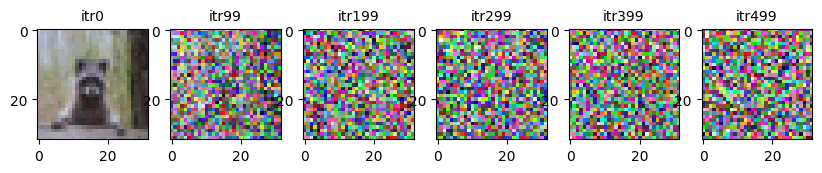

In [10]:
NO_IMG_DISPLAY = 6
img_batch_torch = torch.stack([torch_image]*NO_IMG_DISPLAY)
t = torch.linspace(0,diffusion_model.timesteps-1,NO_IMG_DISPLAY).long()
noisy_img,_ = diffusion_model.forward(img_batch_torch,t,device)

# plt.figure(figsize = (100,100))
f,ax = plt.subplots(1,NO_IMG_DISPLAY,figsize=(10,10))

for i,img in enumerate(noisy_img):
  ax[i].imshow(reverse_transform(img))
  ax[i].set_title(f'itr{t[i].item()}',fontsize=10)



In [11]:
class SinePosEmbeddings(nn.Module):
  def __init__(self,embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim

  def forward(self,time):
    device = time.device
    half_dim = self.embedding_dim//2
    embeddings = math.log(10000)/(half_dim-1)
    embeddings = torch.exp(torch.arange(half_dim,device=device)*-embeddings)
    embeddings = time[:,None]*embeddings[None,:]
    embeddings = torch.cat((embeddings.sin(),embeddings.cos()),dim=-1)
    return embeddings


In [12]:
class Block(nn.Module):
  def __init__(self,in_channel,out_channel,time_emb_dim,labels,num_filter=3,downsample=True):
    super().__init__()
    self.time_emb_dim = time_emb_dim
    self.time_emb = SinePosEmbeddings(time_emb_dim)
    self.labels= labels
    if labels == True:
      self.layer_mlp = nn.Linear(1,out_channel)

    self.downsample = downsample
    if downsample ==True:
      self.conv1 = nn.Conv2d(in_channel,out_channel,num_filter,padding = 1)
      self.final = nn.Conv2d(out_channel,out_channel,4,2,1)
    else :
      self.conv1 = nn.Conv2d(2*in_channel,out_channel,num_filter,padding=1)
      self.final = nn.ConvTranspose2d(out_channel,out_channel,4,2,1)

    self.bnorm1 = nn.BatchNorm2d(out_channel)
    self.bnorm2 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
    self.time_mlp = nn.Linear(time_emb_dim, out_channel)

  def forward(self,x,t,**kwargs):
    o = self.bnorm1(self.relu(self.conv1(x)))
    o_time = self.relu(self.time_mlp(self.time_emb(t)))
    o = o + o_time[...,None,None]
    if self.labels:
      labels = kwargs.get('labels')
      o_labels  = self.relu(self.labels_mlp(labels))
      o = o + o_labels[...,None,None]

    o = self.bnorm2(self.relu(self.conv2(o)))

    return self.final(o)




In [13]:
class UNet(nn.Module):
  def __init__(self,img_channels = 3, time_embeddings_dims = 128, labels = False, sequence_channels =(64, 128, 256, 512, 1024) ):
    super().__init__()
    self.time_embeddings_dims =time_embeddings_dims
    sequence_channels_rev = reversed(sequence_channels)
    self.downsampling = nn.ModuleList([
        Block(in_channel,out_channel,time_embeddings_dims,labels = False,num_filter=3,downsample=True) for in_channel,out_channel in zip(sequence_channels,sequence_channels[1:])
    ])
    self.upsampling = nn.ModuleList([
        Block(in_channel,out_channel,time_embeddings_dims,labels = False,num_filter=3,downsample=False) for in_channel,out_channel in zip(sequence_channels[::-1],sequence_channels[::-1][1:])
    ])
    self.conv1 = nn.Conv2d(img_channels,sequence_channels[0],3,padding=1)
    self.conv2 = nn.Conv2d(sequence_channels[0],img_channels,1)

  def forward(self,x,t,**kwargs):
    o = self.conv1(x)
    residuals = []
    for ds in self.downsampling:
      o = ds(o,t,**kwargs)
      residuals.append(o)
    for us, res in zip(self.upsampling,residuals[::-1]):
      o = us(torch.cat((o,res),dim =1),t,**kwargs)

    return self.conv2(o)


In [14]:
NO_EPOCHS = 1601
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.026811957359314


<Figure size 1500x1500 with 0 Axes>

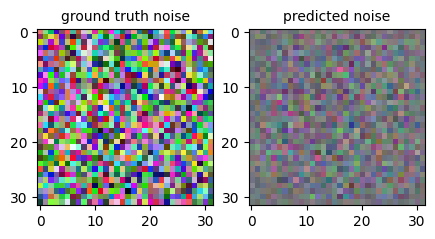

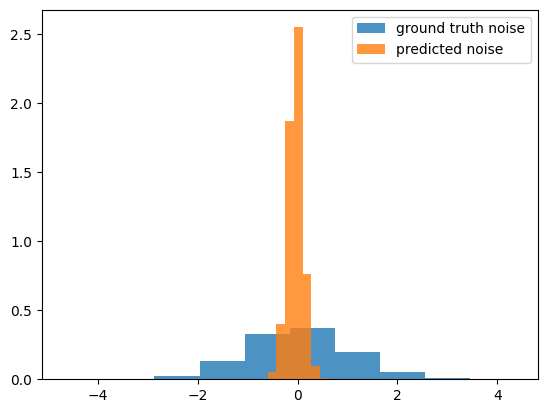

---
Epoch: 400 | Train Loss 0.007006153464317322


<Figure size 1500x1500 with 0 Axes>

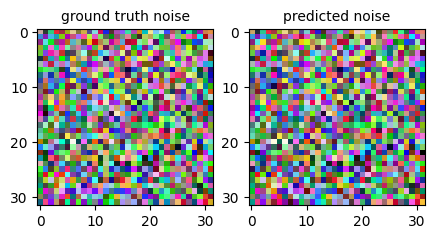

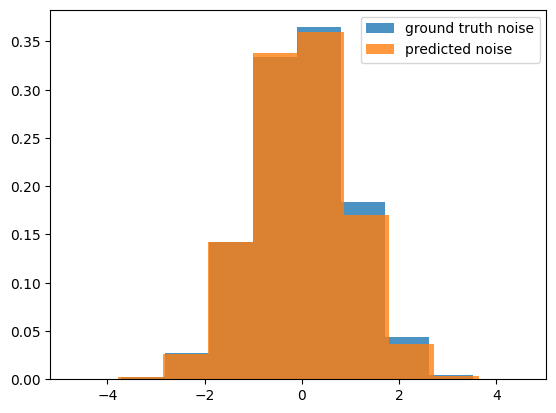

---
Epoch: 800 | Train Loss 0.004465555772185326


<Figure size 1500x1500 with 0 Axes>

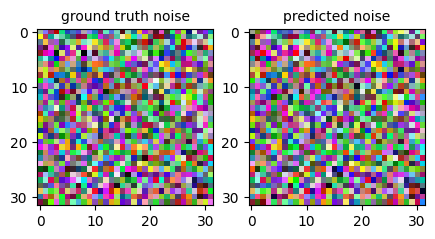

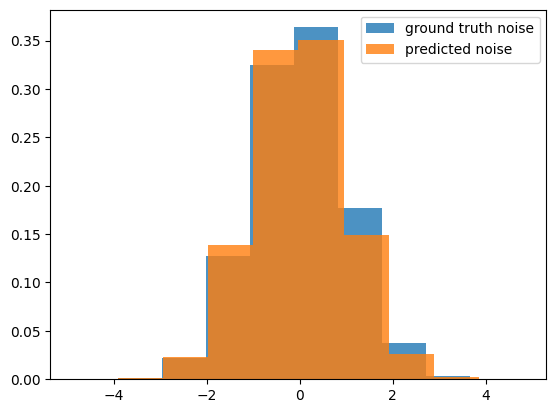

---
Epoch: 1200 | Train Loss 0.0035042758099734783


<Figure size 1500x1500 with 0 Axes>

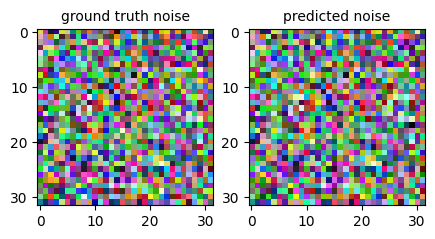

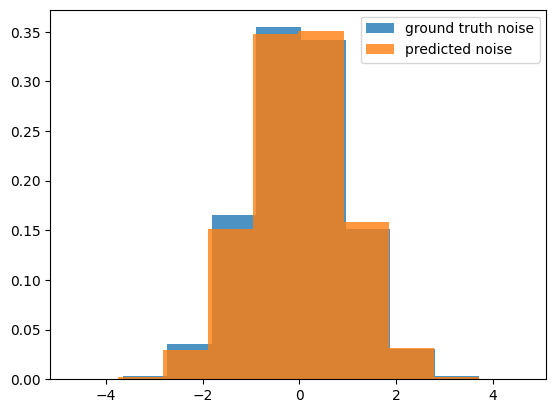

---
Epoch: 1600 | Train Loss 0.0028951908461749554


<Figure size 1500x1500 with 0 Axes>

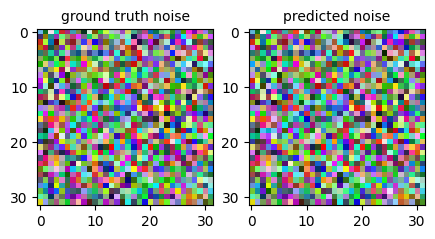

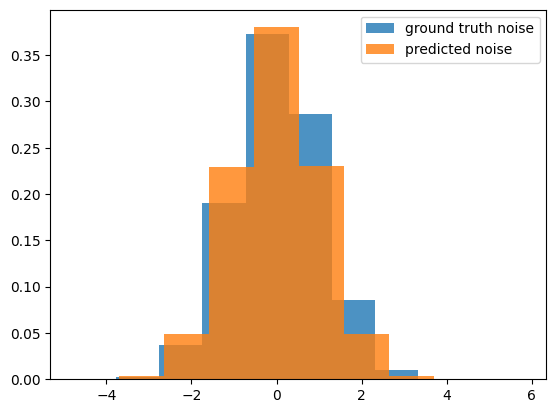

In [15]:
for epoch in range(NO_EPOCHS):
  mean_epoch_loss = []
  batch = torch.stack([torch_image]*BATCH_SIZE)
  t = torch.randint(0,diffusion_model.timesteps,(BATCH_SIZE,)).long().to(device)

  batch_noisy, noise = diffusion_model.forward(batch,t,device)
  pred_noise = unet(batch_noisy,t)

  optimizer.zero_grad()
  loss = torch.nn.functional.mse_loss(pred_noise,noise.to(pred_noise.device))
  mean_epoch_loss.append(loss.item())
  loss.backward()
  optimizer.step()

  if epoch % PRINT_FREQUENCY == 0:
        print('---')

        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], pred_noise[0])
                plot_noise_distribution(noise, pred_noise)

In [16]:
mean_epoch_loss

[0.0028951908461749554]

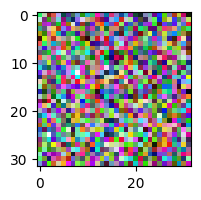

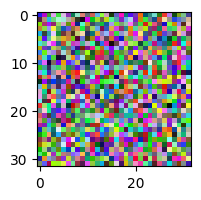

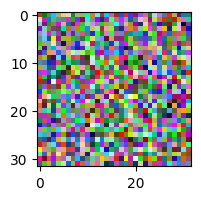

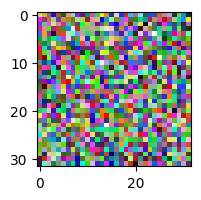

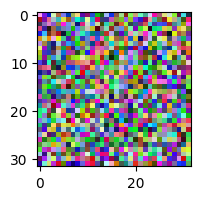

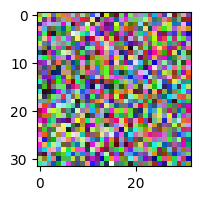

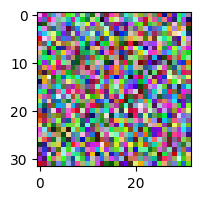

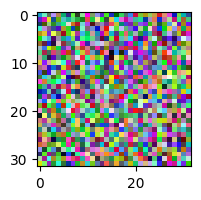

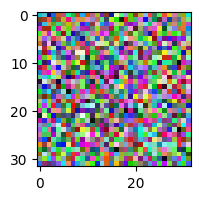

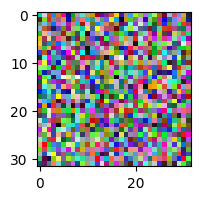

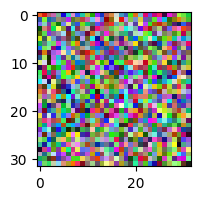

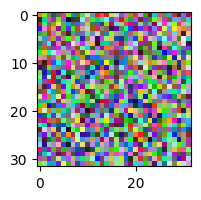

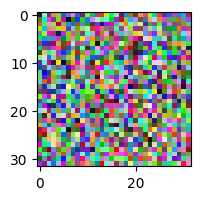

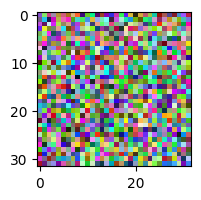

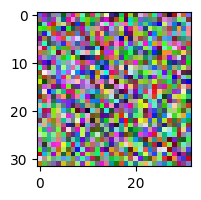

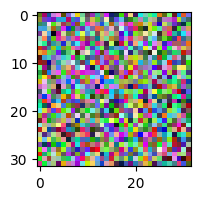

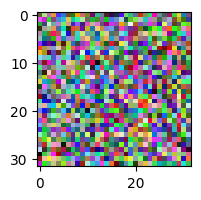

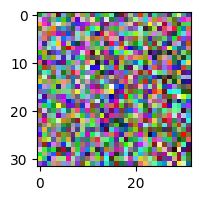

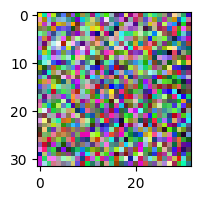

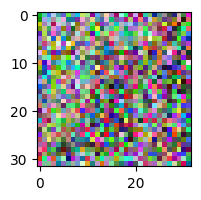

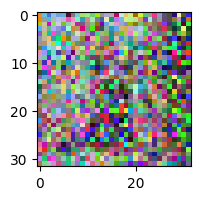

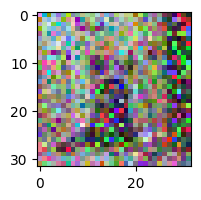

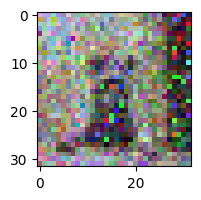

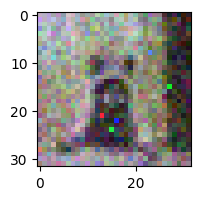

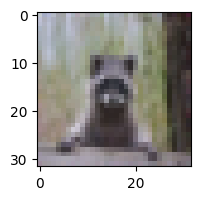

In [17]:
with torch.no_grad():
  img = torch.randn((1,3)+IMG_SIZE).to(device)
  for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    img = diffusion_model.backward(img, t, unet.eval())
    if i%20 ==0:
      plt.figure(figsize=(2,2))
      plt.imshow(reverse_transform(img[0]))
      plt.show()

In [18]:
BATCH_SIZE = 256
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False
unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [19]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 49130215.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [20]:
for epoch in range(NO_EPOCHS):
  mean_epoch_loss = []
  mean_epoch_loss_val = []
  for batch,label in trainloader:
    t = torch.randint(0,diffusion_model.timesteps-1,(BATCH_SIZE,)).long().to(device)
    batch = batch.to(device)
    label = label.to(device)
    batch_noisy, noise = diffusion_model.forward(batch,t,device)
    predicted_noise = unet(batch_noisy,t,labels=label)
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(predicted_noise,noise.to(predicted_noise.device))
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

  for batch,label in testloader:
    t = torch.randint(0,diffusion_model.timesteps-1,(BATCH_SIZE,)).long().to(device)
    batch = batch.to(device)
    label = label.to(device)
    batch_noisy, noise = diffusion_model.forward(batch,t,device)
  if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.11991381673858716 | Val Loss nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---
Epoch: 10 | Train Loss 0.04056958107229991 | Val Loss nan
---
Epoch: 20 | Train Loss 0.03881003978924873 | Val Loss nan
---
Epoch: 30 | Train Loss 0.03781247207751641 | Val Loss nan
---
Epoch: 40 | Train Loss 0.03741977569193412 | Val Loss nan
---
Epoch: 50 | Train Loss 0.03644461040504468 | Val Loss nan
---
Epoch: 60 | Train Loss 0.03626413989143494 | Val Loss nan
---
Epoch: 70 | Train Loss 0.036306627467274664 | Val Loss nan
---
Epoch: 80 | Train Loss 0.03569606366829994 | Val Loss nan
---
Epoch: 90 | Train Loss 0.03612116436736706 | Val Loss nan


In [21]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 80")))

<ipython-input-21-ebc5ec24bc7a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(("epoch: 80")))


<All keys matched successfully>

In [22]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [23]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [24]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))
for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMG_SIZE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((NUM_DISPLAY_IMAGES,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 1500x1500 with 0 Axes>